# MapServer OGC Web Services Workshop

The original [Workshop Material](http://mapserver.github.io/ms-ogc-workshop/).

## Content

**[1. Introduction](#Introduction)**

**[2. WMS](#WMS)**

  * [GetCapabilities](#WMS-GetCapabilities)
  * [DescribeLayer](#DescribeLayer)
  * [GetMap](#GetMap)
  * [GetFeatureInfo](#GetFeatureInfo)
  * [GetStyle](#GetStyle)

**[3. WFS](#WFS)**

  * [GetCapabilities](#WFS-GetCapabilities)
  * [DescribeFeatureType](#DescribeFeatureType)
  * [GetFeature](#GetFeature)


**[4. OGC API - Features](#Collections)**

  * [Collections](#Collections)
  * [Items](#Items)

**[5. WCS](#WCS)**

  * [GetCapabilities](#WCS-GetCapabilities)
  * [DescribeCoverage](#DescribeCoverage)
  * [GetCoverage](#GetCoverage)


----

## Introduction

First of all, you will start by running the following command to ensure that your mapfiles can be used with the latest MapServer version.

Make sure to run this command only once after starting the tale!


In [1]:
!echo ${REPO_DIR}; rm -rf ms-ogc-workshop; git clone https://github.com/MapServer/ms-ogc-workshop.git ; \
    sed "s:/opt/mapserver:${REPO_DIR}/ms-ogc-workshop/service:g;s:/WholeTale/workspace:${REPO_DIR}:g;s:MapServer/ms:ms:g;s:MAPS:MAPS\n    \"config\" \"${REPO_DIR}/ms-ogc-workshop/service/config.map\"\n:g;s:# OGCAPI_HTML_TEMPLATE_DIRECTORY:    OGCAPI_HTML_TEMPLATE_DIRECTORY \"/home/jovyan/.local/templates/html-bootstrap4/\"\n# OGCAPI_HTML_TEMPLATE_DIRECTORY:g" \
        -i ~/.local/etc/mapserver-sample.conf ;\
    for i in ms-ogc-workshop/service/*.map; do \
        echo $i; \
        sed "s:CONFIG:#CONFIG:g;s:DUMP:#DUMP:g;s:COLOR 0 0 255:STYLE COLOR 0 0 255 END:g;" -i $i ; \
        sed "s=http://localhost/cgi-bin/mapserv.exe=http://localhost:8000/cgi-bin/mapserv=g;s=@osgeo4w@/apps=${REPO_DIR}=g;s=@osgeo4w@==g" -i $i ; \
        sed 's:EXTENSION "tif":EXTENSION "tif" \n END \n OUTPUTFORMAT NAME "geojson" DRIVER "OGR/GEOJSON" MIMETYPE "application/json; subtype=geojson"  FORMATOPTION "STORAGE=stream" FORMATOPTION "FORM=SIMPLE" :g' -i $i ; \
        sed 's:"wms_group_title" "Vectors":"wms_group_title" "Vectors" \n "wfs_getfeature_formatlist" "geojson"\n "gml_featureid" "id":g' -i $i ; \
    done ; \
    echo Done

/home/jovyan/work/workspace
Cloning into 'ms-ogc-workshop'...
remote: Enumerating objects: 1001, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1001 (delta 11), reused 13 (delta 1), pack-reused 976
Receiving objects: 100% (1001/1001), 4.40 MiB | 21.90 MiB/s, done.
Resolving deltas: 100% (611/611), done.
ms-ogc-workshop/service/config.map
ms-ogc-workshop/service/exercise_answer.map
ms-ogc-workshop/service/exercise.map
Done


### Rivers layers slight modification

You will start by making sure that the rivers layer get a id column defined. This column will be used as the featureid of the WFS layer/OGC API - Feature collection.

In [2]:
!ogr2ogr ms-ogc-workshop/data/rivers1.shp ms-ogc-workshop/data/rivers.shp -dialect SQLite -sql "select 1 as id, * from rivers" && \
    ogrinfo ms-ogc-workshop/data/rivers1.shp -dialect SQLite -sql "UPDATE rivers1 set ID = rowid" &&\
    mv ms-ogc-workshop/data/rivers1.shp ms-ogc-workshop/data/rivers.shp && \
    mv ms-ogc-workshop/data/rivers1.shx ms-ogc-workshop/data/rivers.shx && \
    mv ms-ogc-workshop/data/rivers1.dbf ms-ogc-workshop/data/rivers.dbf 

INFO: Open of `ms-ogc-workshop/data/rivers1.shp'
      using driver `ESRI Shapefile' successful.


### Util function

You will define a `printXMLResponse` function used to present XML content

In [40]:
import requests, os
from display_xml import XML

def printXMLResponse(url):
    print(url)
    return XML(requests.get(url).content, style='perldoc')

ms_url='http://localhost:8000/cgi-bin/mapserv?' + \
    'map='+os.environ['REPO_DIR']+'/ms-ogc-workshop/service/config.map&'

## WMS

### Overview 

HTTP based (GET or POST)

Operations:

  * GetCapabilities
  * DescribeLayer
  * GetMap
  * GetFeatureInfo

Details:

 * Operation keywords are CaSe-InSeNsItIvE
 * Operation values are case-sensitive
  
  
### WMS GetCapabilities

 * Provides XML of service functionality metadata, and layer metadata
 * Parameters:
   * **Version** (version of specification)‏
   * **Service** (multiple services may exist from this service, e.g. WMS, WFS, WCS)‏
   * **Request** (GetCapabilities)‏ 
 
#### Example

In [41]:
url = ms_url + \
    'version=1.1.1&' + \
    'service=WMS&' + \
    'request=GetCapabilities&'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.1.1&service=WMS&request=GetCapabilities&


### DescribeLayer

OPTIONAL operation to provide more information about a WMS layer (WFS, etc.)

Parameters:
  * **VERSION**
  * **SERVICE**
  * **REQUEST**
  * **LAYERS**

#### Example

In [36]:
url = ms_url + \
    'version=1.1.1&' + \
    'service=WMS&' + \
    'request=DescribeLayer&' + \
    'layers=rivers'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.1.1&service=WMS&request=DescribeLayer&layers=rivers


### GetMap

* Returns graphic image of data based on area of interest, data, etc.
* Image, not features, not attributes
* Parameters
 * version (version of specification)‏
 * service (multiple services may exists from this service, e.g. WMS, WFS, WCS)‏
 * request (GetMap)‏
 * format (image format to be returned)‏
   * Get this from GetCapabilities info
 * bbox (spatial area of interest, i.e. minx,miny,maxx,maxy)‏
 * srs (reference system / projection of bounding box coordinates
   * EPSG (http://www.epsg.org/)‏
   * Get supported SRSs from GetCapabilities
 * Most widely used SRS is EPSG:4326
   * Lat/long geographic (WGS84)‏
 * width (output image width)‏
 * height (output image height)‏
 * layers  (data desired to be visualized)‏
   * Get this from GetCapabilities info
   * Comma-separated list
     * Eg. Layers=elevation,roads,railways,…
     * First list item is bottom most output layer
 * TIME (Not all WMS implementations support TIME)
   * ISO 8601 formatted timestring
   * Single point
   * Frequency
   * Range
   * Current
 * Styles (desired portrayal of data)‏
   * Get this from GetCapabilities info per layer
   * Comma-separated list
     * e.g.. layers=elevation,roads,railways&styles=default,red,blue
     * Style list MUST align with layer list
     * Empty list value for non styled layers
     * e.g. to style ONLY railways layer: layers=elevation,roads,railways&styles=,,blue
 * Styles and SLD
   * SLD enables remote classification and symbolization of data
   * Overrides server-based styles if request from user
   * To use in GetMap, SLD document must exist over HTTP, and cited in GetMap request
     * &sld=http://localhost/ms_ogc_workshop/sld/rivers.sld
     * OR &sld_body=<entire_sld_document>
     * (consider HTTP POST for SLD_BODY)‏
     * More info on SLD later
 * transparent (whether to make non-opaque data pixels transparent
   * Either TRUE or FALSE
   * Useful for layering data from multiple remote WMS services atop eachother for map composition
   * Depends on image format (JPEG is not transparent)‏
   * Depends on web browser support
   * GIF transparency is supported in all browsers
   * PNG transparency support in newer browsers
 * bgcolor (optional background color of image)
 * Exceptions (how to handle errors)‏
   * Can be caused by:
   * Server malfunction
   * Invalid client syntax (missing required values, etc.)‏
     * application/vnd.ogc.se_xml
     * application/vnd.ogc.se_inimage
     * application/vnd.ogc.se_blank
 * Exceptions
   * Which one should I use?
   * application/vnd.ogc.se_inimage
     * Useful for easily visualizing errors in your app
     * Can also be ugly to the end-user / audience
   * application/vnd.ogc.se_blank
     * Returns a blank image
     * Difficult to recognize what type or error has occurred
   * application/vnd.ogc.se_xml
     * Returns an XML exception document
     * Difficult to decode if your app is requesting an image type
     * Choose accordingly



#### Examples

The panel bellow illustrates how you can combine multiple layers in a single GetMap request.


Column(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] Checkbox(name='land_shallow_topo_2048', sizing_mode='stretch_width', value=True)
        [1] Checkbox(name='rivers', sizing_mode='stretch_width', value=True)
    [1] Row(sizing_mode='stretch_width')
        [0] PNG(Image, name='interactive00228', sizing_mode='stretch_width')
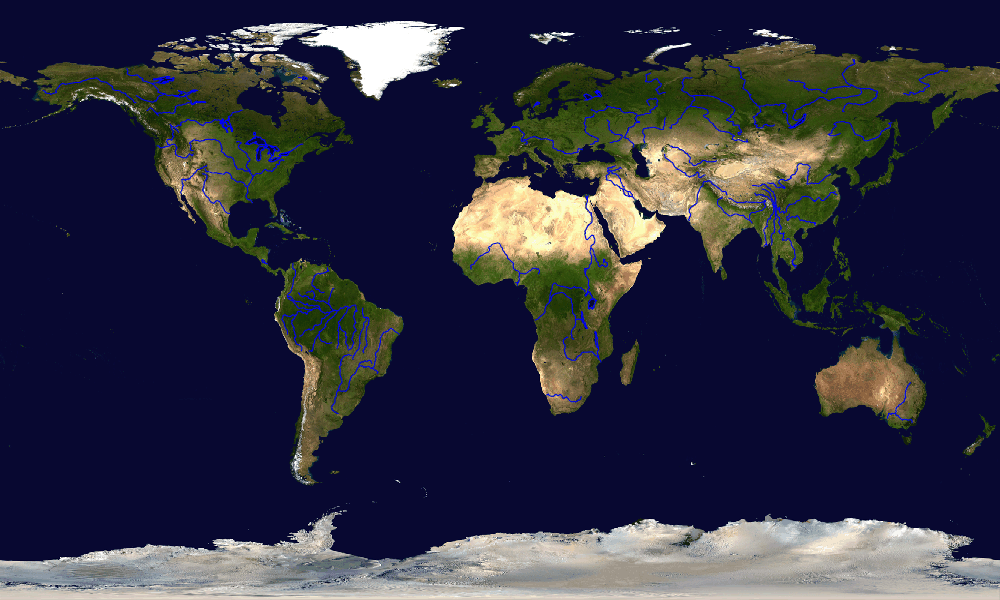

In [55]:
from IPython.display import Image
import requests
import os
import panel as pn

pn.extension()

def showGetMap(land_shallow_topo_2048=True,rivers=True):
    url=ms_url+'version=1.1.1&service=WMS&request=GetMap&srs=EPSG:4326&bbox=-180,-90,180,90&format=image/png&layers='
    if land_shallow_topo_2048:
        url+="land_shallow_topo_2048"
    if rivers:
        if land_shallow_topo_2048:
            url+=','
        url+="rivers"
    url+='&transparent=true&width=1000&height=600&styles=';
    return Image(requests.get(url).content)

pn.interact(showGetMap)


#### Exemple applying a SLD file

In this example, one can change the SLD used to style the data shown on the map and the corresponding legend bellow by using the GetLegendGraphic request.

In [56]:
!cp ms-ogc-workshop/sld/*sld ~/.local/

Column(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] Select(name='sldName', options=['None', 'land_shallow_top...], sizing_mode='stretch_width', value='None')
    [1] Row(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] PNG(Image, sizing_mode='stretch_width')
            [1] PNG(Image, sizing_mode='stretch_width')
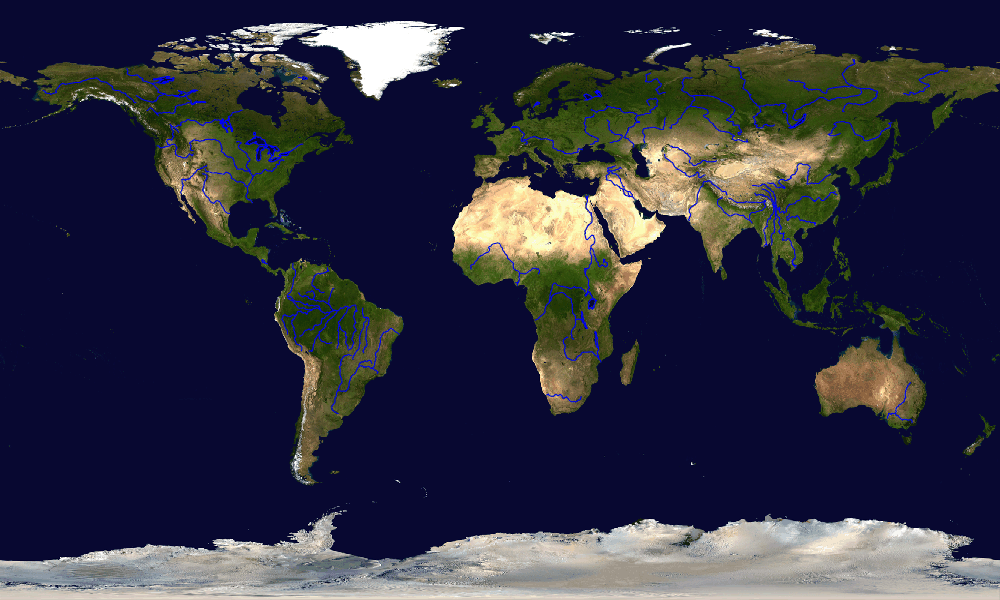

In [57]:
import panel as pn
pn.extension()

def applySLD(sldName='None'):
    url=ms_url+'version=1.1.1&service=WMS&request=GetMap&srs=EPSG:4326&bbox=-180,-90,180,90&format=image/png&layers=land_shallow_topo_2048,rivers&transparent=true&width=1000&height=600&styles=';
    url1=ms_url+'version=1.1.1&service=WMS&request=GetLegendGraphic&srs=EPSG:4326&bbox=-180,-90,180,90&format=image/png&layers=land_shallow_topo_2048,rivers&transparent=true&width=1000&height=600&styles='
    if sldName!="None":
        url+='&sld=http://localhost:8000/'+sldName+'.sld'
        url1+='&sld=http://localhost:8000/'+sldName+'.sld'
    return pn.Column(Image(requests.get(url1).content),Image(requests.get(url).content))
    
slds=[
    "None",
    "land_shallow_topo_2048",
    "rivers",
    "rivers-hilite",
    "rivers-filter"
     ]

kw = dict(sldName=list(slds))

pn.interact(applySLD,**kw)


### GetFeatureInfo


In [10]:
!mkdir -p /home/jovyan/work/workspace/ms-ogc-workshop/service/@osgeo4w@/tmp/ms_tmp/

In [45]:
import panel as pn
from IPython.display import display, HTML
pn.extension()

def runGetFeatureInfo(x=141,y=91,radius=10):
    url = ms_url + \
        'version=1.1.1&' + \
        'service=WMS&' + \
        'request=GetFeatureInfo&' + \
        'srs=EPSG:4326&' + \
        'bbox=-180,-90,180,90&' + \
        'format=image/png&' + \
        'layers=land_shallow_topo_2048,rivers&' + \
        'styles=,&' + \
        'transparent=true&' + \
        'width=500&' + \
        'height=300&' + \
        'query_layers=rivers&' + \
        'info_format=text/html&' + \
        'x='+str(x)+'&' + \
        'y='+str(y)+'&' + \
        'radius='+str(radius)
    return XML(requests.get(url).content)
    
    
#pn.interact(runGetFeatureInfo)

display((runGetFeatureInfo()))


### GetStyle

Convert MapServer classes to OGC SLD documents

In [44]:
url = ms_url + \
    'version=1.1.1&' + \
    'service=WMS&' + \
    'request=GetStyles&' + \
    'layers=rivers'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.1.1&service=WMS&request=GetStyles&layers=rivers



## WFS 

* Feature level access to spatial data (vectors)‏
* Rich query interface 
* Returns GML
* Transactional capability
 * Security considerations for OGC:WFS-T
   * MapServer supports basic WFS
   * No transactions (except using TinyOWS)
* Operations
 * GetCapabilities
 * DescribeFeatureType
 * GetFeature

### WFS GetCapabilities 

* Same idea as OGC:WMS GetCapabilities
* Parameters
 * VERSION
 * SERVICE
 * REQUEST

#### Example

In [46]:
url = ms_url + \
    'version=1.0.0&' + \
    'service=WFS&' + \
    'request=GetCapabilities'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.0.0&service=WFS&request=GetCapabilities



### DescribeFeatureType

* Provides an outline of the structure of a feature type (fields, etc.)‏
* Analogous to SQL describe <table> command
* Parameters
 * VERSION
 * SERVICE
 * REQUEST
 * TYPENAME

#### Examples
    
##### (Default) GML 2

In [47]:
url = ms_url + \
    'version=1.0.0&'+ \
    'service=WFS&' + \
    'request=DescribeFeatureType&' + \
    'typename=rivers'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.0.0&service=WFS&request=DescribeFeatureType&typename=rivers


##### GML 3

By changing the outputformat value, you can switch from GML 2 (default) to GML 3.

In [48]:
url = ms_url + \
    "version=1.0.0&" + \
    "service=WFS&" + \
    "request=DescribeFeatureType&" + \
    "typename=rivers&" + \
    "outputFormat=SFE_XMLSCHEMA"

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.0.0&service=WFS&request=DescribeFeatureType&typename=rivers&outputFormat=SFE_XMLSCHEMA



### GetFeature

* Provides an outline of the structure of a feature type (fields, etc.)‏
* Analogous to SQL describe <table> command
* Parameters
 * VERSION
 * SERVICE
 * REQUEST
 * TYPENAME

#### Examples
    
##### GML 2

In [49]:
url = ms_url + \
    'version=1.0.0&' + \
    'service=WFS&' + \
    'request=GetFeature&' + \
    'typename=rivers&' + \
    'maxfeatures=1'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.0.0&service=WFS&request=GetFeature&typename=rivers&maxfeatures=1


##### GML 3

By changing the outputformat value, you can switch from GML 2 (default) to GML 3.

In [50]:
url = ms_url + \
    'version=1.0.0&' + \
    'service=WFS&' + \
    'request=GetFeature&' + \
    'typename=rivers&' + \
    'maxfeatures=1&' + \
    'outputFormat=GML3'

printXMLResponse(url)


http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.0.0&service=WFS&request=GetFeature&typename=rivers&maxfeatures=1&outputFormat=GML3


Using the specific output format geojson when accessing WFS features permit to get a geojson that can be loaded using geopandas, the first items can then be shown as a table, like so.

In [33]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson

# Specify the url for web feature service

url='http://localhost:8000/cgi-bin/mapserv?map='+os.environ['REPO_DIR']+'/ms-ogc-workshop/service/config.map'

# Specify parameters (read data in json format).
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='rivers',
              outputformat='geojson'
             )

# Fetch data from WFS using requests
r = requests.get(url, params=params)

#print(r.content)

# Create GeoDataFrame from geojson
data = gpd.GeoDataFrame.from_features(geojson.loads(r.content))
# Clean overall cell
# Check the data
data.head()

,geometry,id,NAME,SYSTEM
0,"LINESTRING (124.00678 56.47258, 123.25956 56.6...",0,Aldan,Lena
1,"MULTILINESTRING ((-61.27730 -3.60706, -60.6846...",1,Amazon,Amazon
2,"LINESTRING (73.98818 37.49952, 73.52595 37.528...",2,Amu Darya,
3,"LINESTRING (122.63956 49.99730, 120.47874 49.2...",3,Amur,
4,"LINESTRING (105.07841 51.93053, 103.92959 51.7...",4,Angara,


Now we can use the loaded dataset and overlay with OpenStreetMap tiles using folium.

In [34]:
import folium

import panel as pn

pn.extension(sizing_mode="stretch_width")


m = folium.Map(location=[40, 10], zoom_start=4, control_scale=True, prefer_canvas=True)

folium_pane = pn.pane.plot.Folium(m, height=400)


style = {'fillColor': '#f5f5f5', 'lineColor': '#000000', 'weight': 10.2}    
#polygon = folium.GeoJson(geojson.loads(r.content), style_function = lambda x: style).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff',
                            'color':'#6e6eff', 
                            'fillOpacity': 0.1, 
                            'weight': 6.2}
highlight_function = lambda x: {'fillColor': '#000000',
                                'color':'#ee00ff', 
                                'fillOpacity': 0.50, 
                                'weight': 6.2}
polygon = folium.features.GeoJson(
    data = geojson.loads(r.content),
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME'],
        aliases=['NAME'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
).add_to(m)


folium.LayerControl().add_to(m)

folium_pane.object = m

folium_pane

Folium(Map, height=400)

# OGC API - Features

## Collections



In [28]:
from IPython.core.display import display, JSON
url="http://localhost:8000/cgi-bin/mapserv/config/ogcapi/collections/rivers?f=json"

display(JSON(requests.get(url).content.decode("utf-8")))

<IPython.core.display.JSON object>

## Items


In [30]:
from IPython.core.display import display, JSON
url="http://localhost:8000/cgi-bin/mapserv/config/ogcapi/collections/rivers/items?f=json&limit=100"

display(JSON(requests.get(url).content.decode("utf-8")))

<IPython.core.display.JSON object>

### Example

We can do the same as we did before by using the specific geojson output format as we now directly get the data as geojson per definition of the OGC API - Features specification.

In [15]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson

# Specify the url for web feature service

url="http://localhost:8000/cgi-bin/mapserv/config/ogcapi/collections/rivers/items?f=json&limit=100"

# Specify parameters (read data in json format).
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='rivers',
              outputformat='geojson'
             )

# Fetch data from WFS using requests
r = requests.get(url)

#print(r.content)

# Create GeoDataFrame from geojson
data = gpd.GeoDataFrame.from_features(geojson.loads(r.content))
# Clean overall cell
# Check the data
data.head()

,geometry,NAME,SYSTEM,id
0,"LINESTRING (124.00678 56.47258, 123.25956 56.6...",Aldan,Lena,0
1,"MULTILINESTRING ((-61.27730 -3.60706, -60.6846...",Amazon,Amazon,1
2,"LINESTRING (73.98818 37.49952, 73.52595 37.528...",Amu Darya,,2
3,"LINESTRING (122.63956 49.99730, 120.47874 49.2...",Amur,,3
4,"LINESTRING (105.07841 51.93053, 103.92959 51.7...",Angara,,4


In [16]:
import folium

import panel as pn

pn.extension(sizing_mode="stretch_width")


m = folium.Map(location=[40, 10], zoom_start=4, control_scale=True, prefer_canvas=True)

folium_pane = pn.pane.plot.Folium(m, height=400)


style = {'fillColor': '#f5f5f5', 'lineColor': '#000000', 'weight': 10.2}    
#polygon = folium.GeoJson(geojson.loads(r.content), style_function = lambda x: style).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff',
                            'color':'#6e6eff', 
                            'fillOpacity': 0.1, 
                            'weight': 6.2}
highlight_function = lambda x: {'fillColor': '#000000',
                                'color':'#ee00ff', 
                                'fillOpacity': 0.50, 
                                'weight': 6.2}
polygon = folium.features.GeoJson(
    data = geojson.loads(r.content),
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME'],
        aliases=['NAME'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
).add_to(m)


folium.LayerControl().add_to(m)

folium_pane.object = m

folium_pane

Folium(Map, height=400)


## WCS

* The raster equivalent to OGC:WFS
* Provides “real” raster data
  * DEM
  * GeoTIFF


* Operations
 * GetCapabilities
 * DescribeCoverage
 * GetCoverage

### WCS GetCapabilities

 * Same idea as OGC:WMS GetCapabilities
 * Parameters
  * VERSION
  * SERVICE
  * REQUEST


#### Example

In [51]:
url = ms_url + \
    'version=1.0.0&' + \
    'service=WCS&' + \
    'request=GetCapabilities'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.0.0&service=WCS&request=GetCapabilities



### DescribeCoverage

* Provides an outline of the structure of a coverage
 * bands
 * resolution
* Parameters
  * VERSION
  * SERVICE
  * REQUEST
  * COVERAGE

#### Example

In [52]:
url = ms_url + \
    'version=1.0.0&' + \
    'service=WCS&' + \
    'request=DescribeCoverage&' +\
    'coverage=toronto'

printXMLResponse(url)

http://localhost:8000/cgi-bin/mapserv?map=/home/jovyan/work/workspace/ms-ogc-workshop/service/config.map&version=1.0.0&service=WCS&request=DescribeCoverage&coverage=toronto



### GetCoverage

* Gimme data!
* Parameters:
 * VERSION
 * SERVICE
 * REQUEST
 * COVERAGE
 * CRS
 * BBOX

#### Example

We first store the response provided by the WCS server on the `GetCoverage` request, then we display it using [OpenCV](https://opencv.org/).

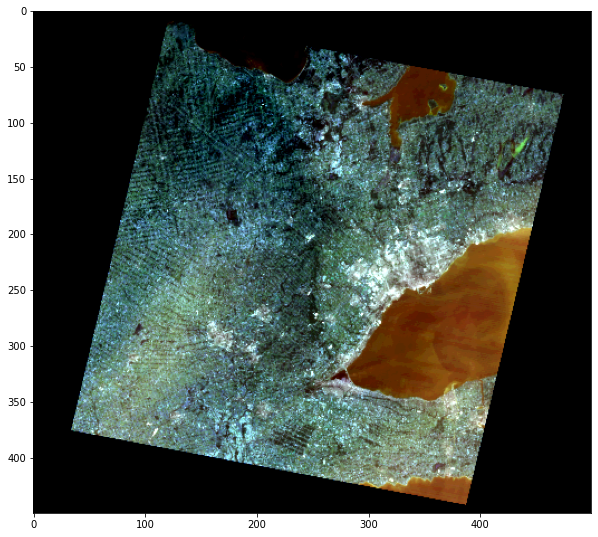

In [54]:
import requests
import os
import cv2
import matplotlib.pyplot as plt
from display_xml import XML

url = ms_url + \
    'version=1.0.0&' + \
    'service=WCS&' + \
    'request=GetCoverage&' + \
    'coverage=toronto&' + \
    'crs=EPSG:26917&' + \
    'resx=500&' + \
    'resy=500&' + \
    'format=GEOTIFF_RGB&' + \
    'BBOX=456850,4732100,706850,4957100'


file=open("./toto.tiff","wb")
file.write(requests.get(url).content)

train_tiffs = os.listdir("./")

for tiff in train_tiffs:
    if tiff.count('tif'):
        im = cv2.imread("./" + tiff)
        plt.figure(figsize = (10,10))
        plt.imshow(im)
        plt.show()